In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import pickle

In [2]:
df = pd.read_csv('data/df_out.csv')
df.shape

(10000, 20)

In [3]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


### Описание датасета

- `id`: идентификатор записи;
- `url`: URL записи о продаже;
- `region`: регион;
- `region_url`: URL региона;
- `price`: стоимость;
- `year`: год выпуска;
- `manufacturer`: производитель;
- `model`: модель;
- `fuel`: тип топлива;
- `odometer`: количество пройденных миль;
- `title_status`: статус;
- `transmission`: коробка передач;
- `image_url`: URL изображения;
- `description`: указанное описание;
- `state`: штат;
- `lat`: широта;
- `long`: долгота;
- `posting_date`: дата размещения объявления о продаже;
- `price_category`: категория цены;
- `date`: дата публикации.

# Data Preparation

## Data cleaning

### Поиск дубликатов

In [4]:
len(df[df.duplicated()])

0

***Дубликатов не выявлено.***

### Выявление выбросов и аномальных значений

##### Выявление выбросов в стоимости автомобиля

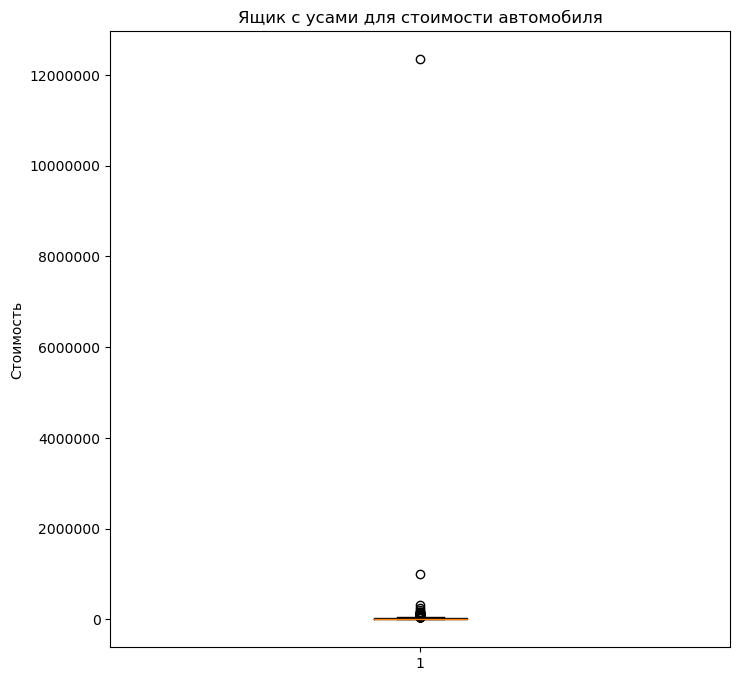

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(df.price)
ax.set_ylabel('Стоимость')
ax.set_title('Ящик с усами для стоимости автомобиля')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [6]:
df.price.describe().apply(lambda x: f'{x:0.3f}')

count       10000.000
mean        20678.415
std        124623.020
min           500.000
25%          7900.000
50%         15749.500
75%         27990.000
max      12345678.000
Name: price, dtype: object

In [7]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [8]:
boundaries_price = calculate_outliers(df.price)
boundaries_price

(-22235.0, 58125.0)

In [9]:
is_outlier_price = (df.price < boundaries_price[0]) | (df.price > boundaries_price[1])
is_outlier_price.sum()

215

In [10]:
len(df[df.price < boundaries_price[0]])

0

***Аномально низких значений не выявлено.***

In [11]:
is_outlier_price.sum() / len(df)

0.0215

In [12]:
df.loc[is_outlier_price, 'price'] = int(boundaries_price[1])

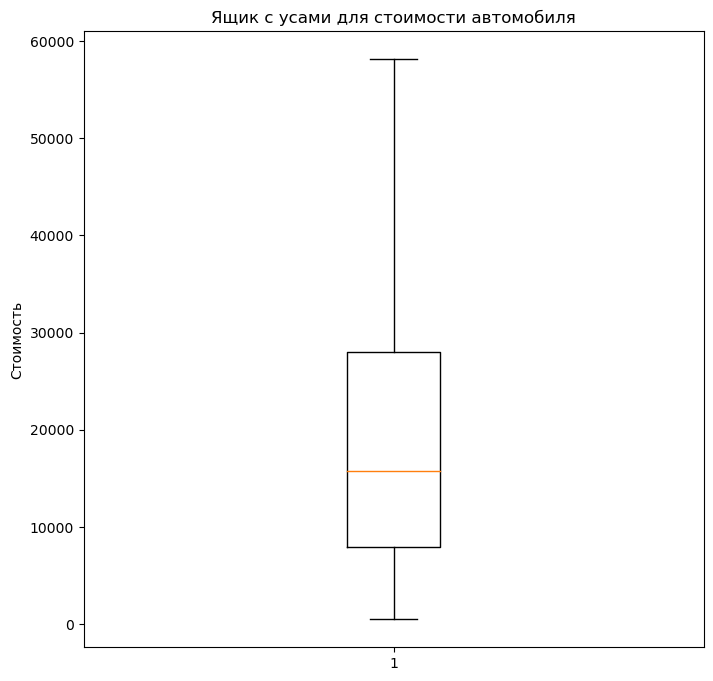

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(df.price)
ax.set_ylabel('Стоимость')
ax.set_title('Ящик с усами для стоимости автомобиля')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

##### Выявление выбросов в годе выпуска автомобиля

Text(0.5, 1.0, 'Распределение года выпуска автомобиля')

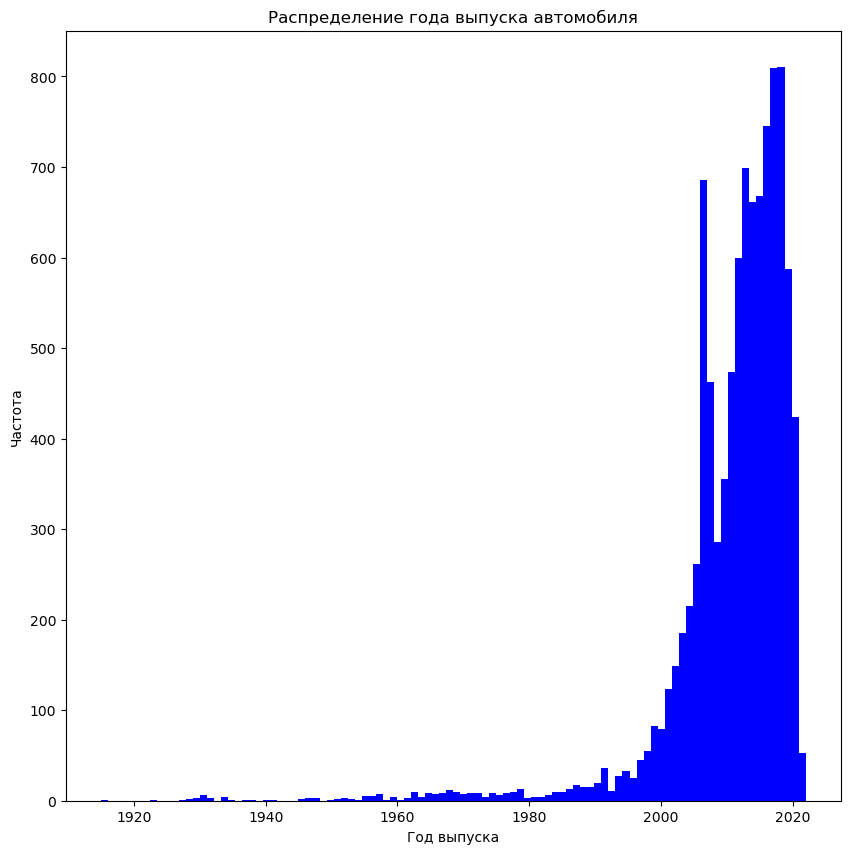

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(df.year, bins=100, color='b')
ax.set_xlabel('Год выпуска')
ax.set_ylabel('Частота')
ax.set_title('Распределение года выпуска автомобиля')

In [15]:
df.year.describe()

count    9964.000000
mean     2010.927941
std         9.672040
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [16]:
boundaries_year = calculate_outliers(df.year)
boundaries_year

(1994.5, 2030.5)

In [17]:
is_outlier_year = (df.year < boundaries_year[0]) | (df.year > boundaries_year[1])
is_outlier_year.sum()

394

***Так как максимальное значение 2022, а верхняя граница нормальных значений 2030, то аномально высоких значений не выявлено.***

In [18]:
is_outlier_year.sum() / len(df)

0.0394

In [19]:
df[is_outlier_year]['price_category'].value_counts()

price_category
low       181
medium    135
high       78
Name: count, dtype: int64

***Большинство выбросов находится среди низкой категории цены.***

In [20]:
df.loc[is_outlier_year, 'year'] = int(boundaries_year[0])

Text(0.5, 1.0, 'Распределение года выпуска автомобиля')

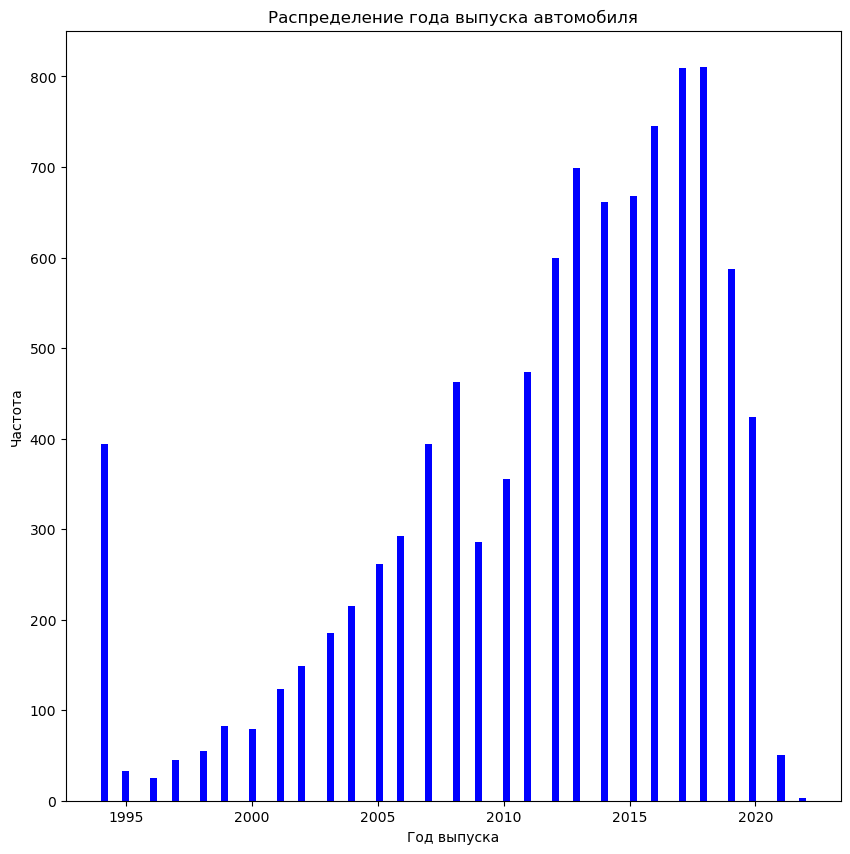

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(df.year, bins=100, color='b')
ax.set_xlabel('Год выпуска')
ax.set_ylabel('Частота')
ax.set_title('Распределение года выпуска автомобиля')

##### Выявление выбросов в количестве пройденных миль

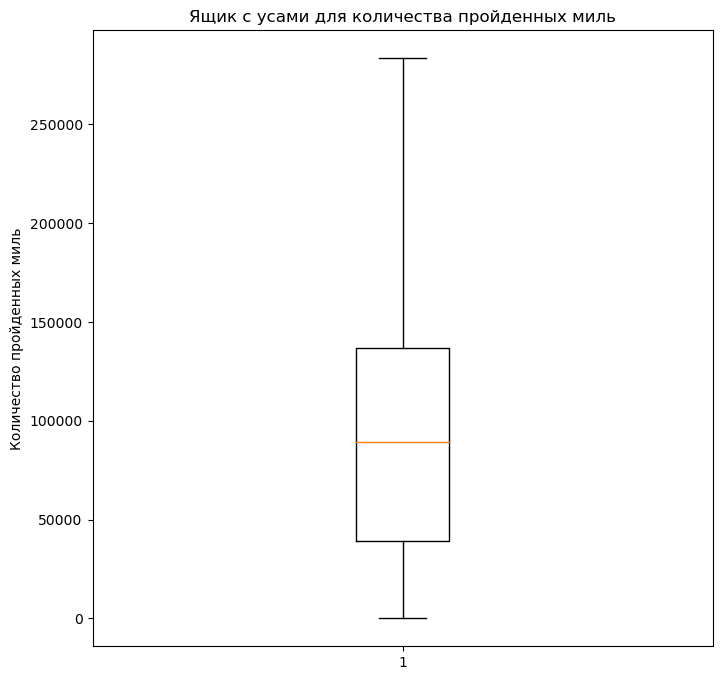

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(df.odometer)
ax.set_ylabel('Количество пройденных миль')
ax.set_title('Ящик с усами для количества пройденных миль')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Text(0.5, 1.0, 'Распределение количества пройденных миль')

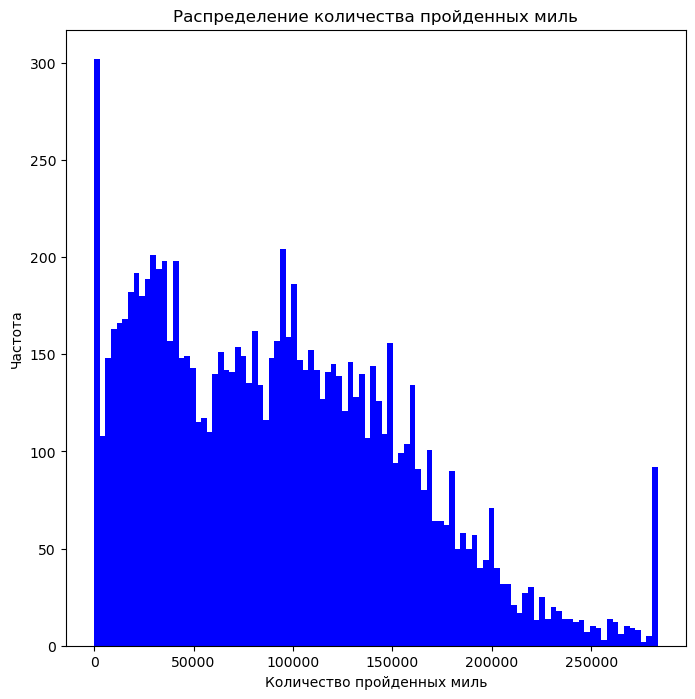

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.hist(df.odometer, bins=100, color='b')
ax.set_xlabel('Количество пройденных миль')
ax.set_ylabel('Частота')
ax.set_title('Распределение количества пройденных миль')

***Аномальных значений не выявлено***

##### Выявление выбросов в широте

Text(0.5, 1.0, 'Распределение широты')

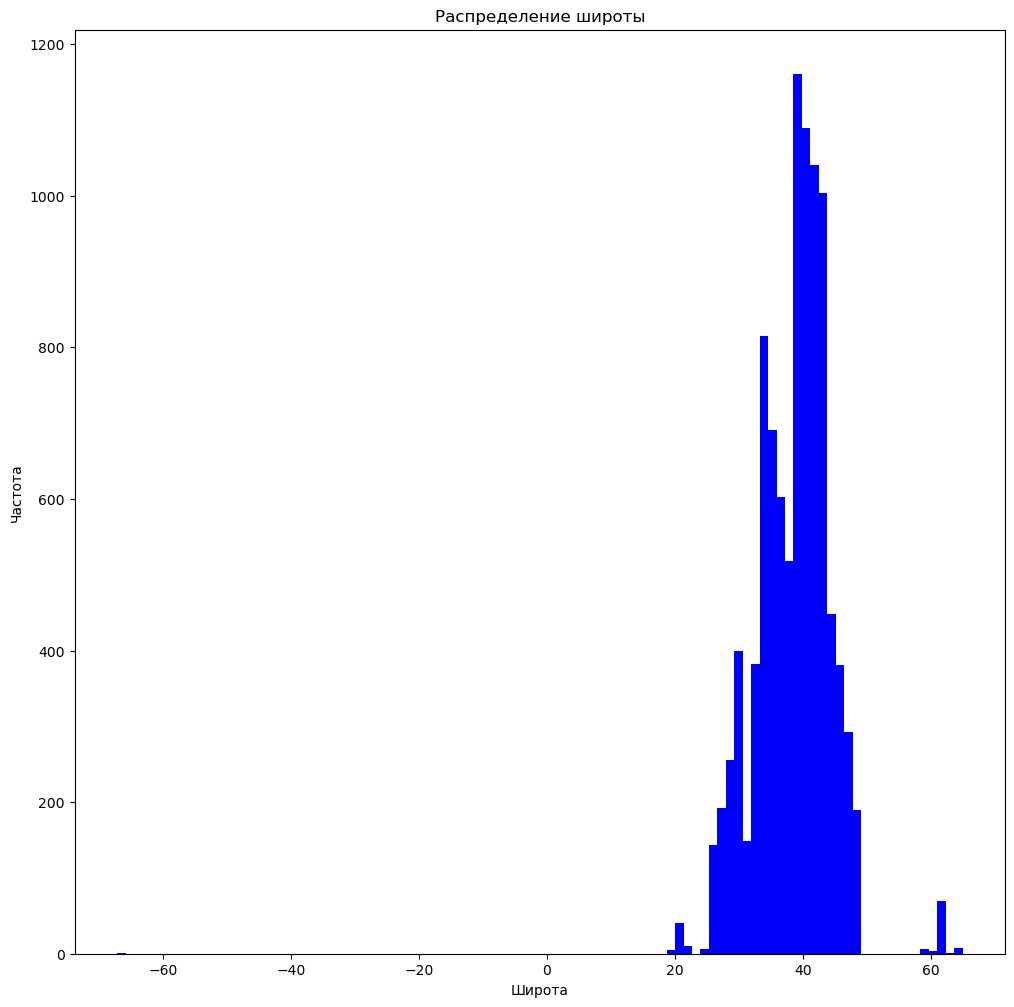

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.hist(df.lat, bins=100, color='b')
ax.set_xlabel('Широта')
ax.set_ylabel('Частота')
ax.set_title('Распределение широты')


In [25]:
df.lat.describe()

count    9902.000000
mean       38.594142
std         5.844895
min       -67.144243
25%        34.830368
50%        39.298522
75%        42.428070
max        64.947500
Name: lat, dtype: float64

In [26]:
boundaries_lat = calculate_outliers(df.lat)
boundaries_lat

(23.433815625, 53.824622624999996)

In [27]:
is_outlier_lat = (df.lat < boundaries_lat[0]) | (df.lat > boundaries_lat[1])
is_outlier_lat.sum()

143

In [28]:
is_outlier_lat.sum() / len(df)

0.0143

In [29]:
df[is_outlier_lat]['price_category'].value_counts()

price_category
high      59
medium    54
low       30
Name: count, dtype: int64

In [30]:
df[df.lat < boundaries_lat[0]]['price_category'].value_counts()

price_category
high      23
medium    17
low       16
Name: count, dtype: int64

In [31]:
df[df.lat > boundaries_lat[1]]['price_category'].value_counts()

price_category
medium    37
high      36
low       14
Name: count, dtype: int64

In [32]:
df.loc[is_outlier_lat, 'lat'] = df.lat.mode()[0]

Text(0.5, 1.0, 'Распределение широты')

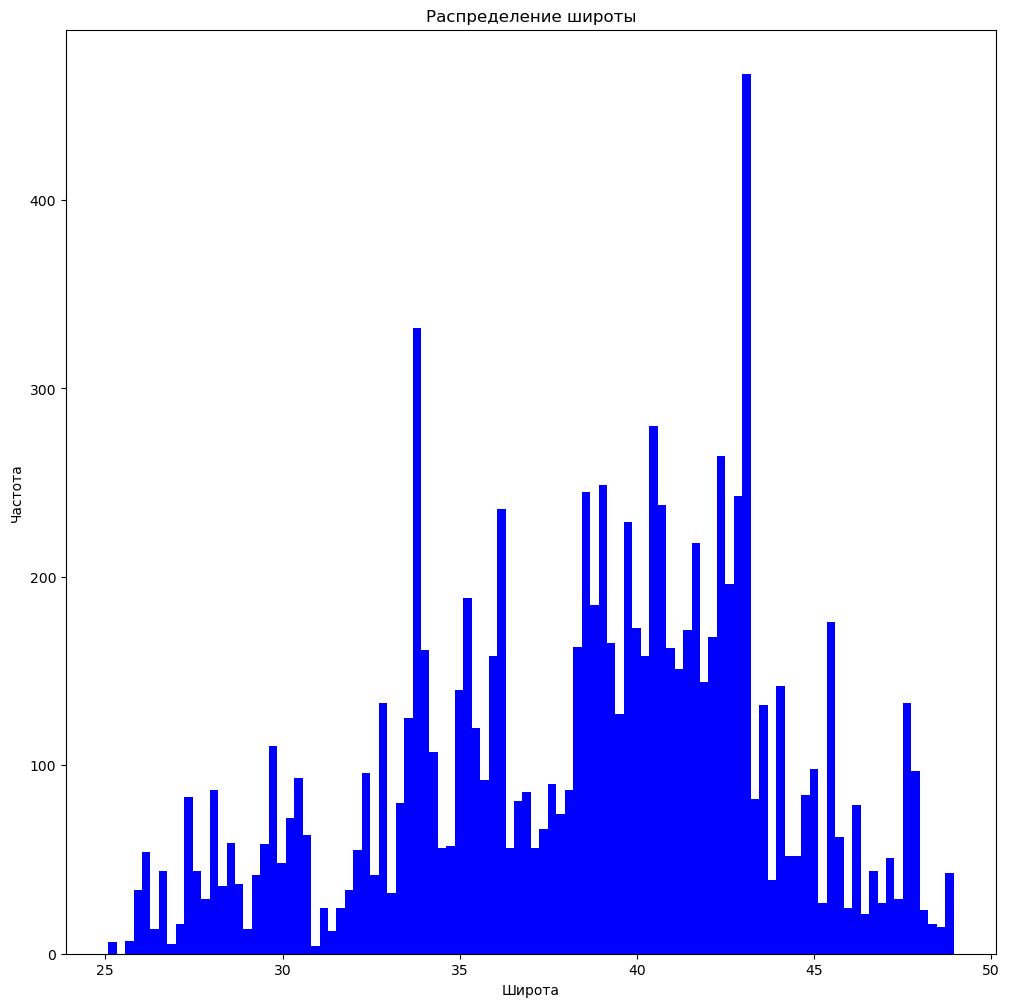

In [33]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.hist(df.lat, bins=100, color='b')
ax.set_xlabel('Широта')
ax.set_ylabel('Частота')
ax.set_title('Распределение широты')

##### Выявление выбросов в долготе

Text(0.5, 1.0, 'Распределение долготы')

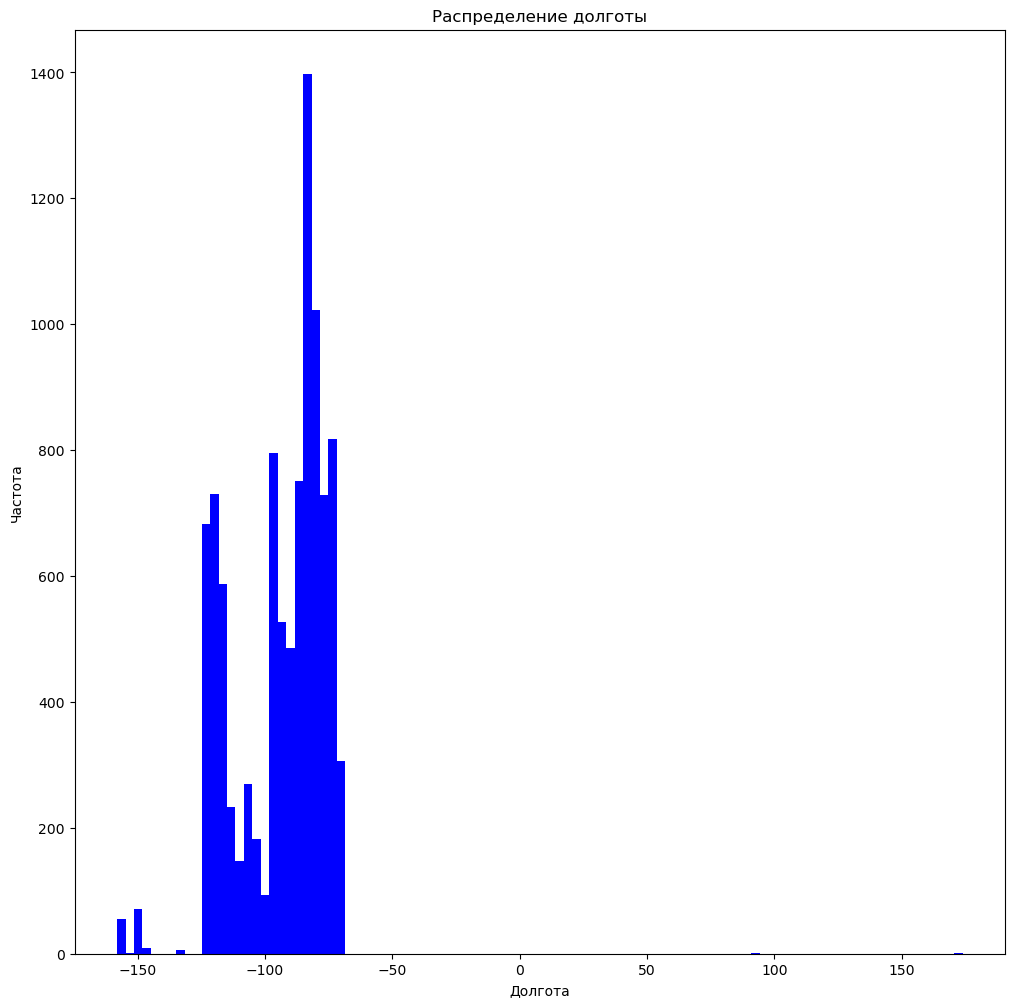

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.hist(df.long, bins=100, color='b')
ax.set_xlabel('Долгота')
ax.set_ylabel('Частота')
ax.set_title('Распределение долготы')


In [35]:
df.long.describe()

count    9902.000000
mean      -94.165877
std        18.128504
min      -158.069300
25%      -110.322086
50%       -88.000050
75%       -80.830000
max       173.885502
Name: long, dtype: float64

In [36]:
boundaries_long = calculate_outliers(df.long)
boundaries_long

(-154.560214375, -36.591871375)

In [37]:
is_outlier_long = (df.long < boundaries_long[0]) | (df.long > boundaries_long[1])
is_outlier_long.sum()

57

In [38]:
is_outlier_long.sum() / len(df)

0.0057

In [39]:
df[is_outlier_long]['price_category'].value_counts()

price_category
high      23
low       17
medium    17
Name: count, dtype: int64

In [40]:
df[df.long < boundaries_long[0]]['price_category'].value_counts()

price_category
high      22
medium    17
low       16
Name: count, dtype: int64

In [41]:
df[df.long > boundaries_long[1]]['price_category'].value_counts()

price_category
high    1
low     1
Name: count, dtype: int64

In [42]:
df.loc[df.long < boundaries_long[0], 'long'] = int(boundaries_long[0])

In [43]:
df.loc[df.long > boundaries_long[1], 'long'] = int(boundaries_long[1])

Text(0.5, 1.0, 'Распределение долготы')

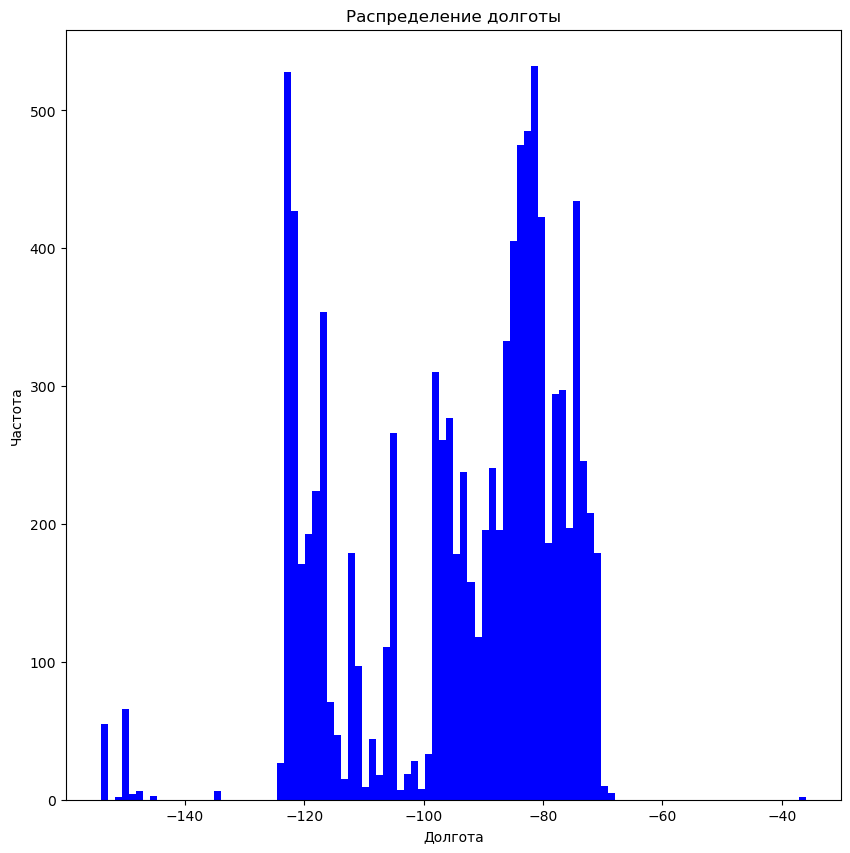

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(df.long, bins=100, color='b')
ax.set_xlabel('Долгота')
ax.set_ylabel('Частота')
ax.set_title('Распределение долготы')

### Выявление пропущенных значений

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

In [46]:
def useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', 
          len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', 
          round(len(df.dropna()) / len(df) * 100, 2))
useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 9507
Процент полностью заполненных объектов из всей выборки: 95.07


In [47]:
def missing_values(data):
    values = ((data.isna().sum() / len(df)) * 100).sort_values(ascending=False)
    return values

In [48]:
missing_list = missing_values(df)
print('Пропущенные значения есть в столбцах: \n',
      missing_list[missing_list.values > 0].index.tolist())

Пропущенные значения есть в столбцах: 
 ['title_status', 'model', 'long', 'lat', 'fuel', 'transmission', 'year', 'posting_date', 'description', 'image_url', 'date']


#### Обработка пропусков в статусе автомобиля

In [49]:
df.title_status.value_counts(dropna=False)

title_status
clean         9518
rebuilt        171
NaN            166
salvage         92
lien            35
missing         16
parts only       2
Name: count, dtype: int64

In [50]:
df.title_status.describe()

count      9834
unique        6
top       clean
freq       9518
Name: title_status, dtype: object

In [51]:
df.title_status= df.title_status.fillna(df.title_status.mode()[0])

In [52]:
print("Количество пропущенных значений в title_status:", df.title_status.isna().sum())

Количество пропущенных значений в title_status: 0


#### Обработка пропусков в модели автомобиля

In [53]:
df.model.value_counts(dropna=False)

model
f-150                        151
NaN                          128
silverado 1500               110
1500                         100
camry                         77
                            ... 
grand caravan sport            1
Nascar                         1
titan le                       1
sorrento lx v6                 1
a3 2.0t premium plus pzev      1
Name: count, Length: 3467, dtype: int64

In [54]:
df.model.describe()

count      9872
unique     3466
top       f-150
freq        151
Name: model, dtype: object

In [55]:
df.model = df.model.fillna('other')

In [56]:
print("Количество пропущенных значений в model:", df.model.isna().sum()) 

Количество пропущенных значений в model: 0


#### Обработка пропусков долготы автомобиля

In [57]:
df.long.value_counts(dropna=False)

long
 NaN           98
-84.112200     88
-84.411811     79
-74.281707     73
-154.000000    55
               ..
-85.180435      1
-88.841600      1
-95.787429      1
-81.451631      1
-79.189500      1
Name: count, Length: 5039, dtype: int64

In [58]:
df.long.describe()

count    9902.000000
mean      -94.181351
std        17.780893
min      -154.000000
25%      -110.322086
50%       -88.000050
75%       -80.830000
max       -36.000000
Name: long, dtype: float64

In [59]:
df['long'] = df['long'].fillna(int(df['long'].mean()))

In [60]:
print("Количество пропущенных значений в long:", df.long.isna().sum()) 

Количество пропущенных значений в long: 0


#### Обработка пропусков широты автомобиля

In [61]:
df.lat.value_counts(dropna=False)

lat
43.182400    231
NaN           98
33.779214     79
40.468785     73
33.786500     54
            ... 
32.660500      1
39.783470      1
35.716918      1
44.923961      1
42.123900      1
Name: count, Length: 4965, dtype: int64

In [62]:
df.lat.describe()

count    9902.000000
mean       38.568172
std         5.202314
min        25.080000
25%        34.952868
50%        39.372365
75%        42.462894
max        48.937200
Name: lat, dtype: float64

In [63]:
df['lat'] = df['lat'].fillna(int(df['lat'].mean()))

In [64]:
print("Количество пропущенных значений в lat:", df.lat.isna().sum()) 

Количество пропущенных значений в lat: 0


#### Обработка пропусков в типе топлива

In [65]:
df.fuel.value_counts(dropna=False)

fuel
gas         8402
other        730
diesel       653
hybrid       108
NaN           63
electric      44
Name: count, dtype: int64

In [66]:
df.fuel.describe()

count     9937
unique       5
top        gas
freq      8402
Name: fuel, dtype: object

In [67]:
df.fuel = df.fuel.fillna('other')

In [68]:
print("Количество пропущенных значений в fuel:", df.fuel.isna().sum())  

Количество пропущенных значений в fuel: 0


#### Обработка пропусков в коробке передач

In [69]:
df.transmission.value_counts(dropna=False)

transmission
automatic    7700
other        1624
manual        631
NaN            45
Name: count, dtype: int64

In [70]:
df.transmission.describe()

count          9955
unique            3
top       automatic
freq           7700
Name: transmission, dtype: object

In [71]:
df.transmission = df.transmission.fillna('other')

In [72]:
print("Количество пропущенных значений в transmission:", df.transmission.isna().sum())

Количество пропущенных значений в transmission: 0


#### Обработка пропусков в годе выпуска

In [73]:
df.year.value_counts(dropna=False)

year
2018.0    810
2017.0    809
2016.0    745
2013.0    699
2015.0    668
2014.0    661
2012.0    599
2019.0    587
2011.0    473
2008.0    462
2020.0    424
1994.0    394
2007.0    394
2010.0    355
2006.0    292
2009.0    286
2005.0    262
2004.0    215
2003.0    185
2002.0    149
2001.0    123
1999.0     82
2000.0     79
1998.0     55
2021.0     50
1997.0     45
NaN        36
1995.0     33
1996.0     25
2022.0      3
Name: count, dtype: int64

In [74]:
df['year'].isna().sum()

36

In [75]:
df.year.describe()

count    9964.000000
mean     2011.669410
std         6.516981
min      1994.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [76]:
df['year'] = df['year'].fillna(int(df['year'].mean()))

In [77]:
print("Количество пропущенных значений в year:", df['year'].isna().sum())

Количество пропущенных значений в year: 0


**Изменение типа данных года выпуска**

In [78]:
df['year'] = df['year'].astype('int64')
df['year'].dtype

dtype('int64')

#### Обработка пропусков в столбцах: 'posting_date', 'date'

In [79]:
df['posting_date'].isna().sum()

2

In [80]:
df['posting_date'] = df['posting_date'].fillna(df['posting_date'].mode()[0])

In [81]:
print("Количество пропущенных значений в posting_date:", df['posting_date'].isna().sum())

Количество пропущенных значений в posting_date: 0


In [82]:
df['date'].isna().sum()

2

In [83]:
df['date'] = df['date'].fillna(df['date'].mode()[0])

In [84]:
print("Количество пропущенных значений в date:", df['date'].isna().sum())

Количество пропущенных значений в date: 0


#### Обработка пропусков в столбцах: 'description', 'image_url'

In [85]:
df['description'].isna().sum()

2

In [86]:
df['image_url'].isna().sum()

2

In [87]:
df['description'] = df['description'].fillna('NaN')

In [88]:
df['image_url'] = df['image_url'].fillna('NaN')

In [89]:
print("Количество пропущенных значений в description:", df['description'].isna().sum())

Количество пропущенных значений в description: 0


In [90]:
print("Количество пропущенных значений в image_url:", df['image_url'].isna().sum())

Количество пропущенных значений в image_url: 0


# Feature Engineering

## Генерация дополнительных фичей

In [91]:
df['year'].describe()

count    10000.000000
mean      2011.667000
std          6.505363
min       1994.000000
25%       2008.000000
50%       2013.000000
75%       2017.000000
max       2022.000000
Name: year, dtype: float64

In [92]:
df['age_category'] =  df.apply(lambda x: "new" if x.year > 2015 else ("old" if x.year < 2008 else "average"), axis=1)

In [93]:
df[['year', 'age_category']]

,year,age_category
0,2020,new
1,2016,new
2,2017,new
3,2013,average
4,2021,new
...,...,...
9995,2002,old
9996,2008,average
9997,2011,average
9998,2015,average


In [94]:
df['model_len'] = df.apply(lambda x: len(x.model) , axis=1)
df['model_len']

0       22
1       20
2       16
3        4
4        6
        ..
9995     4
9996     8
9997    25
9998     7
9999    22
Name: model_len, Length: 10000, dtype: int64

In [95]:
df['model_word_count'] = df.apply(lambda x: len(x.model.split(' ')) , axis=1)
df['model_word_count']

0       5
1       4
2       3
3       1
4       1
       ..
9995    1
9996    1
9997    5
9998    1
9999    5
Name: model_word_count, Length: 10000, dtype: int64

In [96]:
manufacturer_names = ['audi', 'ford', 'chevrolet', 'toyota', 'jeep', 'honda', 'nissan']

for manufacturer in manufacturer_names:
    col_name = 'is_' + manufacturer
    
    df[col_name] = df.apply(lambda x: 1 if x.manufacturer == manufacturer else 0, axis=1)

In [97]:
df.iloc[:, -7:]

,is_audi,is_ford,is_chevrolet,is_toyota,is_jeep,is_honda,is_nissan
0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
9995,0,0,0,1,0,0,0
9996,0,0,0,0,1,0,0
9997,1,0,0,0,0,0,0
9998,0,0,0,0,0,0,0


In [98]:
df.description

0       Carvana is the safer way to buy a car During t...
1       ***Call Us for more information at: 201-635-14...
2       Carvana is the safer way to buy a car During t...
3       2013 Toyota RAV4 XLE 4dr SUV     Offered by: R...
4       2021 Nissan Altima Sv with Only 8 K Miles Titl...
                              ...                        
9995    Transmission:Automatic Exterior Color:WHITE In...
9996    2008 Jeep Wrangler X  Offered by: R&L Auto -- ...
9997    2011 Audi A3 2.0T Premium Plus PZEV Wagon2011 ...
9998    2015 Porsche Cayenne AWD 4dr S E-Hybrid - $31,...
9999    Carvana is the safer way to buy a car During t...
Name: description, Length: 10000, dtype: object

In [99]:
df['desc_len'] = df.apply(lambda x: len(x.description) , axis=1)
df['desc_len']

0       4482
1        968
2       4286
3       3241
4        538
        ... 
9995    1710
9996     948
9997     909
9998    3644
9999    4483
Name: desc_len, Length: 10000, dtype: int64

In [100]:
df['model_in_desc'] = df.apply(lambda x: x.description.count(x.model) , axis=1)

In [101]:
df['model_in_desc'].value_counts()

model_in_desc
0     8804
1      824
2      104
3       57
5       34
4       25
16      16
9       14
14      11
7       11
8       10
6        9
28       9
15       9
17       8
18       7
20       5
11       4
23       3
19       3
25       3
31       3
27       3
22       3
13       3
29       2
10       2
35       2
26       2
56       1
39       1
36       1
30       1
32       1
49       1
34       1
54       1
63       1
12       1
Name: count, dtype: int64

## Преобразование строковых признаков

In [102]:
df.model.value_counts()

model
f-150                        151
other                        128
silverado 1500               110
1500                         100
camry                         77
                            ... 
grand caravan sport            1
Nascar                         1
titan le                       1
sorrento lx v6                 1
a3 2.0t premium plus pzev      1
Name: count, Length: 3467, dtype: int64

In [103]:
df.model.nunique()

3467

In [104]:
df['short_model'] = df.model.apply(lambda x: x.lower().split(' ')[0])
df['short_model']

0           2500
1       explorer
2           golf
3           rav4
4         altima
          ...   
9995        rav4
9996    wrangler
9997          a3
9998     cayenne
9999        1500
Name: short_model, Length: 10000, dtype: object

In [105]:
df['short_model'].nunique()

940

## Преобразование категориальных переменных

In [106]:
categories = ['short_model', 'transmission', 'fuel', 'region', 'manufacturer', 'state', 'title_status', 'age_category']

for cat in categories:
    print(cat, df[cat].nunique())

short_model 940
transmission 3
fuel 5
region 393
manufacturer 40
state 51
title_status 6
age_category 3


In [107]:
data = df[categories]
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[categories])
ohe_data = ohe.transform(df[categories])

In [108]:
feature_names = ohe.get_feature_names_out()
ohe_df = pd.DataFrame(ohe_data, columns=feature_names)

In [109]:
df = pd.concat([df, ohe_df], axis=1)

In [110]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,state_wy,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,age_category_average,age_category_new,age_category_old
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Преобразование признаков на основе дат

In [111]:
df.date = pd.to_datetime(df['date'])

In [112]:
df.posting_date = pd.to_datetime(df['posting_date'])

In [114]:
df.apply(lambda x: x.posting_date.month, axis=1)

0       4
1       5
2       4
3       4
4       5
       ..
9995    4
9996    5
9997    4
9998    4
9999    4
Length: 10000, dtype: int64

In [115]:
df.apply(lambda x: x.date.month, axis=1)

0       4
1       5
2       4
3       4
4       5
       ..
9995    4
9996    5
9997    4
9998    4
9999    4
Length: 10000, dtype: int64

In [116]:
df = df.assign(month = df.apply(lambda x: x.date.month, axis=1))
df.month

0       4
1       5
2       4
3       4
4       5
       ..
9995    4
9996    5
9997    4
9998    4
9999    4
Name: month, Length: 10000, dtype: int64

In [117]:
df = df.assign(dayofweek = df.date.dt.dayofweek)
df.dayofweek

0       5
1       0
2       2
3       5
4       0
       ..
9995    5
9996    0
9997    3
9998    2
9999    5
Name: dayofweek, Length: 10000, dtype: int32

In [118]:
df = df.assign(diff_years = df.apply(lambda x: (x.date.year - x.year), axis=1))
df.diff_years

0        1
1        5
2        4
3        8
4        0
        ..
9995    19
9996    13
9997    10
9998     6
9999     4
Name: diff_years, Length: 10000, dtype: int64

## Стандартизация данных

In [119]:
new_data = ['odometer', 'lat', 'long', 'year', 'desc_len', 'model_in_desc', 'model_len', 'model_word_count', 'month', 'dayofweek', 'diff_years']
data = df[new_data]

In [120]:
std_scaler = StandardScaler()
std_scaler.fit(data)

StandardScaler()

In [121]:
std_scaled = std_scaler.transform(data)

In [122]:
new_data = [elem + '_std' for elem in new_data]

In [123]:
std_df = pd.DataFrame(std_scaled, columns=new_data)

In [124]:
df = pd.concat([df, std_df], axis=1)

In [125]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,lat_std,long_std,year_std,desc_len_std,model_in_desc_std,model_len_std,model_word_count_std,month_std,dayofweek_std,diff_years_std
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,-0.676596,0.504705,1.281007,0.606640,-0.164475,1.159786,1.909905,-0.612485,1.115383,-1.281007
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.436409,1.137059,0.666099,-0.659192,-0.164475,0.929345,1.235385,1.632694,-1.374089,-0.666099
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,-0.924005,0.552080,0.819826,0.536036,-0.164475,0.468463,0.560864,-0.612485,-0.378300,-0.819826
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,-0.549886,0.877441,0.204918,0.159600,-0.164475,-0.914182,-0.788177,-0.612485,1.115383,-0.204918
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,0.404148,1.162621,1.434734,-0.814088,-0.164475,-0.683741,-0.788177,1.632694,-1.374089,-1.434734


## Подготовка датафрейма для этапа моделирования

In [126]:
columns_for_drop = ['year', 'url', 'region', 'region_url', 'manufacturer',
                    'model', 'fuel', 'odometer', 'title_status', 'transmission',
                    'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
                    'desc_len', 'model_in_desc', 'age_category', 'model_len', 'model_word_count',
                    'short_model', 'date', 'month', 'dayofweek', 'diff_years']

In [127]:
df_prepared=df.drop(columns=columns_for_drop)

In [128]:
df_prepared.columns

Index(['id', 'price', 'price_category', 'is_audi', 'is_ford', 'is_chevrolet',
       'is_toyota', 'is_jeep', 'is_honda', 'is_nissan',
       ...
       'lat_std', 'long_std', 'year_std', 'desc_len_std', 'model_in_desc_std',
       'model_len_std', 'model_word_count_std', 'month_std', 'dayofweek_std',
       'diff_years_std'],
      dtype='object', length=1462)

In [129]:
df_prepared.shape

(10000, 1462)

In [130]:
df_prepared.to_csv('data/df_out__prepared.csv', index=False)

# Modelling

In [131]:
df = pd.read_csv('data/df_out__prepared.csv')

In [132]:
df_prepared = df.copy()
df_prepared = df_prepared.drop(['price', 'id'], axis=1)

In [133]:
x = df_prepared.drop(['price_category'], axis=1)
y = df_prepared.price_category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Случайный лес

In [134]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

RandomForestClassifier()

In [135]:
predicted_train_rf = rf_clf.predict(x_train)
predicted_test_rf = rf_clf.predict(x_test)

In [136]:
print(accuracy_score(y_train, predicted_train_rf))
print(accuracy_score(y_test, predicted_test_rf))

1.0
0.7803333333333333


## Логистическая регрессия

In [137]:
logreg = LogisticRegression(max_iter=1000, C=3)

In [138]:
logreg.fit(x_train, y_train)

LogisticRegression(C=3, max_iter=1000)

In [139]:
logreg_train = logreg.predict(x_train)
logreg_test = logreg.predict(x_test)

In [140]:
print(accuracy_score(y_train, logreg_train))
print(accuracy_score(y_test, logreg_test))

0.8762857142857143
0.7796666666666666


## Многослойный персептрон

In [141]:
mlp = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(100,20), activation = 'tanh')
mlp.fit(x_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 20), max_iter=500,
              random_state=42)

In [142]:
mlp_train = mlp.predict(x_train)
mlp_test = mlp.predict(x_test)

In [143]:
print(accuracy_score(y_train, mlp_train))
print(accuracy_score(y_test, mlp_test))

1.0
0.7883333333333333


# Results

По результатам моделирования наилучший результат показала модель многослойного персептрона.

In [144]:
mlp.fit(x, y)

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 20), max_iter=500,
              random_state=42)

In [145]:
filename = 'model.pickle'

with open(filename, 'wb') as file:
    pickle.dump(mlp, file)

In [146]:
with open(filename, 'rb') as f:
    model_from_pickle = pickle.load(f)

In [147]:
model_from_pickle

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 20), max_iter=500,
              random_state=42)

In [148]:
row = df.sample(1)
row_x = row[x.columns]
row_y = row['price_category']

In [149]:
model_from_pickle.predict(row_x)

array(['medium'], dtype='<U6')

In [150]:
row_y

9814    medium
Name: price_category, dtype: object